In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cpu


In [5]:
class CustomMnistDataset(Dataset):
    def __init__(self, csv_file, transform=None, is_test=False):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        item = self.data_frame.iloc[index]

        if self.is_test:
            image = item.values.reshape(28,28).astype(np.uint8)
            label = None
        else:
            image = item[1:].values.reshape(28,28).astype(np.uint8)
            label = item.iloc[0]


        image = transforms.ToPILImage()(image)

        if self.transform is not None:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            return image, label        

In [6]:
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [7]:
train_dataset = CustomMnistDataset(csv_file='/kaggle/input/digit-recognizer/train.csv', transform=transform, is_test=False)
test_dataset = CustomMnistDataset(csv_file='/kaggle/input/digit-recognizer/test.csv', transform=transform, is_test=True)

In [8]:
print('Train Size: ' + str(len(train_dataset)) + ', Test Size: ' + str(len(test_dataset)))

Train Size: 42000, Test Size: 28000


In [9]:
train_dataset[1]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [10]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Input Size: torch.Size([64, 1, 28, 28])


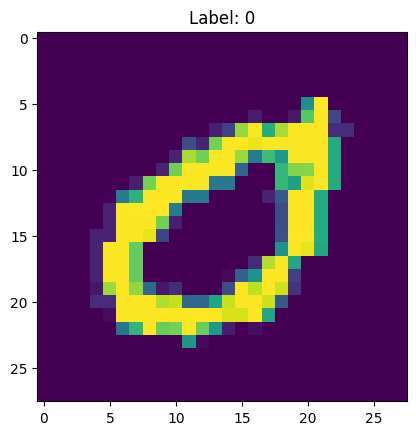

In [11]:
for example_data, example_labels in train_loader:
    example_image = example_data[0]
    print('Input Size:', example_data.size())

    example_image_numpy = example_image.permute(1, 2, 0).numpy()

    plt.imshow(example_image_numpy)
    plt.title(f"Label: {example_labels[0]}")
    plt.show()

    break

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128*7*7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 20)
        self.fc3 = nn.Linear(20,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.pool(x)

        x_size = x.size(1) * x.size(2) * x.size(3)

        x = x.view(-1, x_size)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
        

In [13]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num_epochs = 20
running_loss = 0.0

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%100 == 99:
            print(f"[{epoch + 1}, {i+1}] Loss: {running_loss/100:.3f}")
            running_loss = 0.0
            
print("Training Finished")

[1, 100] Loss: 2.301
[1, 200] Loss: 2.282
[1, 300] Loss: 2.245
[1, 400] Loss: 2.098
[1, 500] Loss: 1.506
[1, 600] Loss: 0.802
[2, 100] Loss: 0.816
[2, 200] Loss: 0.426
[2, 300] Loss: 0.381
[2, 400] Loss: 0.368
[2, 500] Loss: 0.326
[2, 600] Loss: 0.307
[3, 100] Loss: 0.449
[3, 200] Loss: 0.235
[3, 300] Loss: 0.242
[3, 400] Loss: 0.220
[3, 500] Loss: 0.198


In [ ]:
model.eval()
predictions = []

with torch.no_grad():
  for data in test_loader:
    data = data.to(device)

    outputs = model(data)
    __, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.cpu().tolist())

  submission = pd.DataFrame({
      'ImageId': range(1, len(predictions) + 1),
      'Label': predictions})
  
  submission.to_csv('predictions123final.csv', index=False)